<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/pytorch/t81_558_class_04_2_multi_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import io
import copy

try:
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Early stopping (see Module 3.4)
class EarlyStopping():
    def __init__(self, patience=15, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
    
    def __call__(self, model, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model.load_state_dict(model.state_dict())
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model.state_dict())
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

# Make use of a GPU or MPS (Apple) if one is available. (see Module 3.2)
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: using Google CoLab
Using device: mps


In [6]:
import pandas as pd
import dwong

dwong.os.chdir("/Users/wongdowling/Desktop/DQ_Dowling/electron/csv/")
df = pd.read_csv("pure_emcal.csv")
pd.set_option('display.max_columns', 5)
pd.set_option('display.max_rows', 5)

display(df)

,label,wew_x,...,kurt_x,kurt_y
0,1.0,1.584334,...,-0.465606,0.150234
1,1.0,2.007739,...,-0.427125,-0.075675
...,...,...,...,...,...
7527,0.0,3.554478,...,0.100684,1.116287
7528,0.0,6.758660,...,0.245580,0.126966


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', 
                            cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.6f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
x=df[["wew_x","wew_y", "wid_x", "wid_y", "skew_x","skew_y", "kurt_x","kurt_y"]].values
y=df['label'].values

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from sklearn import preprocessing
from torch.utils.data import DataLoader, TensorDataset
import tqdm
import time

# Define the PyTorch Neural Network
class Net(nn.Module):
    def __init__(self, in_count, out_count):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_count, 50)
        self.fc2 = nn.Linear(50, 25)
        self.fc3 = nn.Linear(25, out_count)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

# Split into validation and training sets
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

# Numpy to Torch Tensor
x_train = torch.Tensor(x_train).float()
y_train = torch.Tensor(y_train).float()

x_test = torch.Tensor(x_test).float().to(device)
y_test = torch.Tensor(y_test).float().to(device)


# Create datasets
BATCH_SIZE = 16

dataset_train = TensorDataset(x_train, y_train)
dataloader_train = DataLoader(dataset_train,\
  batch_size=BATCH_SIZE, shuffle=True)

dataset_test = TensorDataset(x_test, y_test)
dataloader_test = DataLoader(dataset_test,\
  batch_size=BATCH_SIZE, shuffle=True)


# Create model
model = Net(x.shape[1],1).to(device)

loss_fn = nn.BCELoss()# Binary Cross Entropy loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
es = EarlyStopping()

epoch = 0
done = False
while epoch<1000 and not done:
    epoch += 1
    steps = list(enumerate(dataloader_train))
    pbar = tqdm.tqdm(steps)
    model.train()
    for i, (x_batch, y_batch) in pbar:
        y_batch_pred = model(x_batch.to(device))
        loss = loss_fn(y_batch_pred, y_batch.reshape(-1,1).to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (i + 1)* len(x_batch)
        if i == len(steps)-1:
            model.eval()
            pred = model(x_test)
            vloss = loss_fn(pred, y_test.reshape(-1,1))
            if es(model,vloss): done = True
            pbar.set_description(f"Epoch: {epoch}, tloss: {loss}, vloss: {vloss:>7f}, EStop:[{es.status}]")
        else:
            pbar.set_description(f"Epoch: {epoch}, tloss {loss:}")

Epoch: 1, tloss: 0.30626553297042847, vloss: 0.370546, EStop:[0/15]: 100%|█| 353
Epoch: 2, tloss: 0.4884456396102905, vloss: 0.376676, EStop:[1/15]: 100%|█| 353/
Epoch: 3, tloss: 0.6407229900360107, vloss: 0.356673, EStop:[0/15]: 100%|█| 353/
Epoch: 4, tloss: 0.2602088749408722, vloss: 0.367956, EStop:[1/15]: 100%|█| 353/
Epoch: 5, tloss: 0.40836814045906067, vloss: 0.361067, EStop:[2/15]: 100%|█| 353
Epoch: 6, tloss: 0.5660731792449951, vloss: 0.357833, EStop:[3/15]: 100%|█| 353/
Epoch: 7, tloss: 0.497168630361557, vloss: 0.354983, EStop:[0/15]: 100%|█| 353/3
Epoch: 8, tloss: 0.346983402967453, vloss: 0.375277, EStop:[1/15]: 100%|█| 353/3
Epoch: 9, tloss: 0.45136287808418274, vloss: 0.354447, EStop:[0/15]: 100%|█| 353
Epoch: 10, tloss: 0.286428302526474, vloss: 0.358714, EStop:[1/15]: 100%|█| 353/
Epoch: 11, tloss: 0.3659578263759613, vloss: 0.355589, EStop:[2/15]: 100%|█| 353
Epoch: 12, tloss: 0.21400003135204315, vloss: 0.351233, EStop:[0/15]: 100%|█| 35
Epoch: 13, tloss: 0.43288326

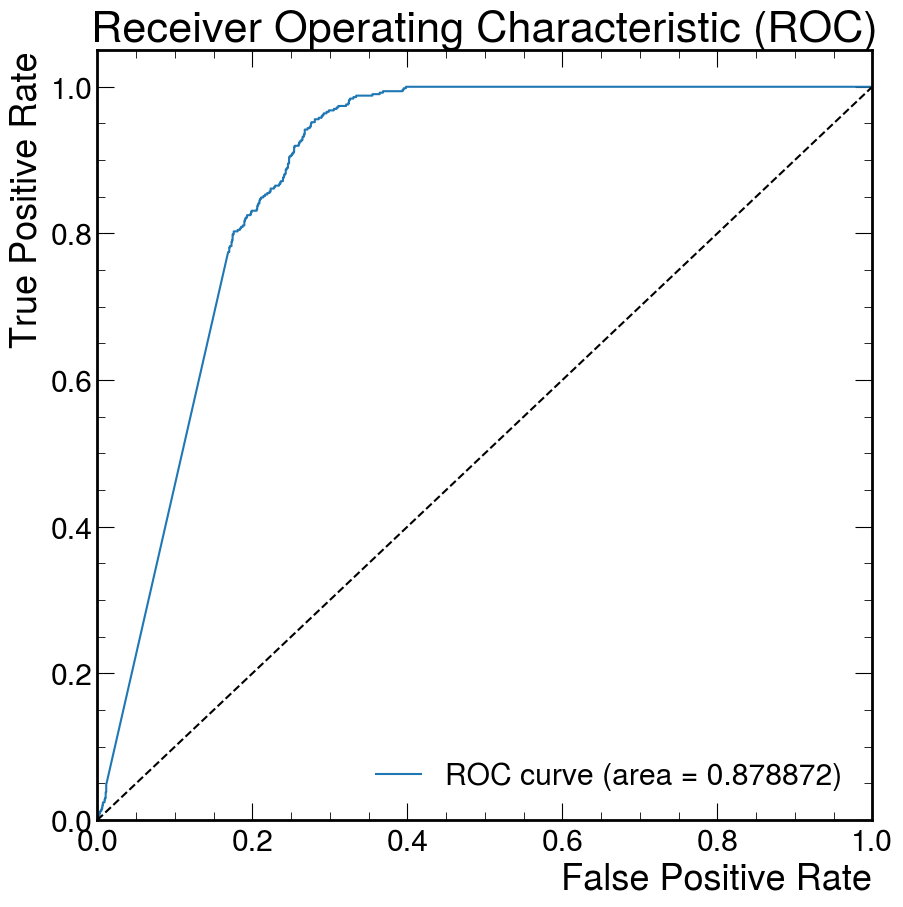

In [10]:
pred = model(x_test)
plot_roc(pred.cpu().detach(),y_test.cpu())

### Multiclass Classification Error Metrics

If you want to predict more than one outcome, you will need more than one output neuron. Because a single neuron can predict two results, a neural network with two output neurons is somewhat rare. If there are three or more outcomes, there will be three or more output neurons. The following sections will examine several metrics for evaluating classification error. We will assess the following classification neural network.

In [8]:
import pandas as pd
from scipy.stats import zscore

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/toys.csv",
    na_values=['NA','?'])

# Generate dummies for material
df = pd.concat([df,pd.get_dummies(df['material'],prefix="material")],axis=1)
df.drop('material', axis=1, inplace=True)

# Missing values for depth
med = df['depth'].median()
df['depth'] = df['depth'].fillna(med)

df['pieces'] = zscore(df['pieces'])
df['length'] = zscore(df['length'])
df['height'] = zscore(df['height'])
df['depth'] = zscore(df['depth'])
df['weight'] = zscore(df['weight'])

# Convert to numpy - Classification
x_columns = df.columns.drop('toy') #.drop('id')
x = df[x_columns].values

le = preprocessing.LabelEncoder()
y = le.fit_transform(df['toy'])
products = le.classes_

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from sklearn import preprocessing
from torch.utils.data import DataLoader, TensorDataset
import tqdm
import time

# Define the PyTorch Neural Network
class Net(nn.Module):
    def __init__(self, in_count, out_count):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_count, 50)
        self.fc2 = nn.Linear(50, 25)
        self.fc3 = nn.Linear(25, out_count)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.softmax(self.fc3(x))

# Split into validation and training sets
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

# Numpy to Torch Tensor
x_train = torch.Tensor(x_train).float()
y_train = torch.Tensor(y_train).long()

x_test = torch.Tensor(x_test).float().to(device)
y_test = torch.Tensor(y_test).long().to(device)


# Create datasets
BATCH_SIZE = 16

dataset_train = TensorDataset(x_train, y_train)
dataloader_train = DataLoader(dataset_train,\
  batch_size=BATCH_SIZE, shuffle=True)

dataset_test = TensorDataset(x_test, y_test)
dataloader_test = DataLoader(dataset_test,\
  batch_size=BATCH_SIZE, shuffle=True)


# Create model
model = Net(x.shape[1],len(products)).to(device)

loss_fn = nn.CrossEntropyLoss()# cross entropy loss

optimizer = torch.optim.Adam(model.parameters()) # , lr=0.01
es = EarlyStopping()

epoch = 0
done = False
while epoch<1000 and not done:
  epoch += 1
  steps = list(enumerate(dataloader_train))
  pbar = tqdm.tqdm(steps)
  model.train()
  for i, (x_batch, y_batch) in pbar:
    y_batch_pred = model(x_batch.to(device))
    loss = loss_fn(y_batch_pred, y_batch.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss, current = loss.item(), (i + 1)* len(x_batch)
    if i == len(steps)-1:
      model.eval()
      pred = model(x_test)
      vloss = loss_fn(pred, y_test)
      if es(model,vloss): done = True
      pbar.set_description(f"Epoch: {epoch}, tloss: {loss}, vloss: {vloss:>7f}, EStop:[{es.status}]")
    else:
      pbar.set_description(f"Epoch: {epoch}, tloss {loss:}")

Epoch: 1, tloss: 1.257548213005066, vloss: 1.375472, EStop:[0/5]: 100%|██████████| 469/469 [00:03<00:00, 121.56it/s]
Epoch: 2, tloss: 1.3585182428359985, vloss: 1.324934, EStop:[0/5]: 100%|██████████| 469/469 [00:03<00:00, 125.56it/s]
Epoch: 3, tloss: 1.4308271408081055, vloss: 1.302584, EStop:[0/5]: 100%|██████████| 469/469 [00:03<00:00, 118.69it/s]
Epoch: 4, tloss: 1.22785484790802, vloss: 1.284166, EStop:[0/5]: 100%|██████████| 469/469 [00:04<00:00, 102.67it/s]
Epoch: 5, tloss: 1.3159691095352173, vloss: 1.274265, EStop:[0/5]: 100%|██████████| 469/469 [00:05<00:00, 92.87it/s]
Epoch: 6, tloss: 1.3040297031402588, vloss: 1.270644, EStop:[0/5]: 100%|██████████| 469/469 [00:04<00:00, 103.87it/s]
Epoch: 7, tloss: 1.2140861749649048, vloss: 1.266139, EStop:[0/5]: 100%|██████████| 469/469 [00:04<00:00, 100.16it/s]
Epoch: 8, tloss: 1.3081793785095215, vloss: 1.264112, EStop:[0/5]: 100%|██████████| 469/469 [00:04<00:00, 108.39it/s]
Epoch: 9, tloss: 1.255907416343689, vloss: 1.259594, EStop:[

### Calculate Classification Accuracy
 
Accuracy is the number of rows where the neural network correctly predicted the target class.  Accuracy is only used for classification, not regression.

$$ accuracy = \frac{c}{N} $$

Where $c$ is the number correct and $N$ is the size of the evaluated set (training or validation). Higher accuracy numbers are desired.

As we just saw, by default, Keras will return the percent probability for each class. We can change these prediction probabilities into the actual iris predicted with **argmax**.

In [10]:
pred = model(x_test)
_, predict_classes = torch.max(pred, 1)

Now that we have the actual iris flower predicted, we can calculate the percent accuracy (how many were correctly classified).

In [11]:
from sklearn import metrics

score = metrics.accuracy_score(y_test, predict_classes)
print("Accuracy score: {}".format(score))

Accuracy score: 0.9216


### Calculate Classification Log Loss

Accuracy is like a final exam with no partial credit.  However, neural networks can predict a probability of each of the target classes.  Neural networks will give high probabilities to predictions that are more likely.  Log loss is an error metric that penalizes confidence in wrong answers. Lower log loss values are desired.

The following code shows the output of predict_proba:


In [12]:
from IPython.display import display

# Don't display numpy in scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Generate predictions
pred = model(x_test)

print("Numpy array of predictions")
display(pred[0:5])

print("As percent probability")
print(pred[0]*100)

score = metrics.log_loss(y_test, pred.detach())
print("Log loss score: {}".format(score))

# raw probabilities to chosen class (highest probability)
_, predict_classes = torch.max(pred, 1)

Numpy array of predictions


tensor([[2.2512e-03, 4.0209e-13, 9.9775e-01, 1.2051e-10, 2.9743e-12, 3.3444e-21,
         1.3973e-19],
        [2.2550e-03, 1.1054e-09, 9.9775e-01, 6.0721e-16, 8.1237e-15, 1.8963e-10,
         1.8360e-15],
        [2.4687e-15, 7.7643e-28, 2.1730e-11, 1.0000e+00, 1.2639e-11, 8.8688e-34,
         1.1679e-37],
        [2.6318e-10, 3.8210e-10, 3.5693e-19, 1.3996e-17, 4.3010e-21, 9.9997e-01,
         3.1845e-05],
        [1.9823e-12, 3.7044e-23, 6.7478e-11, 1.0000e+00, 4.3859e-09, 5.8011e-31,
         3.3435e-31]], grad_fn=<SliceBackward0>)

As percent probability
tensor([2.2512e-01, 4.0209e-11, 9.9775e+01, 1.2051e-08, 2.9743e-10, 3.3444e-19,
        1.3973e-17], grad_fn=<MulBackward0>)
Log loss score: 0.5052632994303051


[Log loss](https://www.kaggle.com/wiki/LogarithmicLoss) is calculated as follows:

$$ \mbox{log loss} = -\frac{1}{N}\sum_{i=1}^N {( {y}_i\log(\hat{y}_i) + (1 - {y}_i)\log(1 - \hat{y}_i))} $$


You should use this equation only as an objective function for classifications that have two outcomes. The variable y-hat is the neural network’s prediction, and the variable y is the known correct answer.  In this case, y will always be 0 or 1.  The training data have no probabilities. The neural network classifies it either into one class (1) or the other (0).  

The variable N represents the number of elements in the training set the number of questions in the test.  We divide by N because this process is customary for an average.  We also begin the equation with a negative because the log function is always negative over the domain 0 to 1.  This negation allows a positive score for the training to minimize.

You will notice two terms are separated by the addition (+).  Each contains a log function.  Because y will be either 0 or 1, then one of these two terms will cancel out to 0.  If y is 0, then the first term will reduce to 0.  If y is 1, then the second term will be 0.  

If your prediction for the first class of a two-class prediction is y-hat, then your prediction for the second class is 1 minus y-hat.  Essentially, if your prediction for class A is 70% (0.7), then your prediction for class B is 30% (0.3).  Your score will increase by the log of your prediction for the correct class.  If the neural network had predicted 1.0 for class A, and the correct answer was A, your score would increase by log (1), which is 0. For log loss, we seek a low score, so a correct answer results in 0.  Some of these log values for a neural network's probability estimate for the correct class:

* -log(1.0) = 0
* -log(0.95) = 0.02
* -log(0.9) = 0.05
* -log(0.8) = 0.1
* -log(0.5) = 0.3
* -log(0.1) = 1
* -log(0.01) = 2
* -log(1.0e-12) = 12
* -log(0.0) = negative infinity

As you can see, giving a low confidence to the correct answer affects the score the most.  Because log (0) is negative infinity, we typically impose a minimum value.  Of course, the above log values are for a single training set element.  We will average the log values for the entire training set.

The log function is useful to penalizing wrong answers.  The following code demonstrates the utility of the log function:

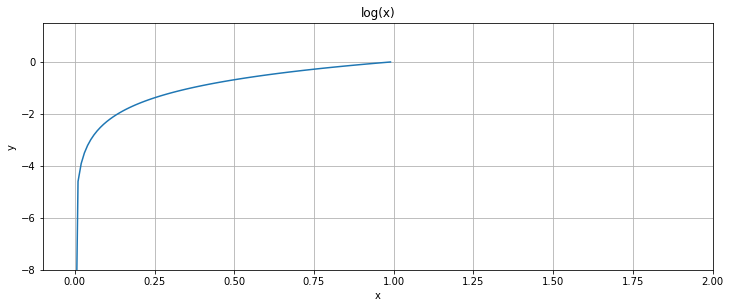

In [13]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from numpy import arange, sin, pi

#t = arange(1e-5, 5.0, 0.00001)
#t = arange(1.0, 5.0, 0.00001) # computer scientists
t = arange(1e-6, 1.0, 1e-2)  # data     scientists

fig = figure(1,figsize=(12, 10))

ax1 = fig.add_subplot(211)
ax1.plot(t, np.log(t))
ax1.grid(True)
ax1.set_ylim((-8, 1.5))
ax1.set_xlim((-0.1, 2))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('log(x)')

show()

### Confusion Matrix

A confusion matrix shows which predicted classes are often confused for the other classes. The vertical axis (y) represents the true labels and the horizontal axis (x) represents the predicted labels. When the true label and predicted label are the same, the highest values occur down the diagonal extending from the upper left to the lower right. The other values, outside the diagonal, represent incorrect predictions. For example, in the confusion matrix below, the value in row 2, column 1 shows how often the predicted value A occurred when it should have been B.

Normalized confusion matrix
[[0.64 0.   0.27 0.   0.   0.01 0.08]
 [0.   0.99 0.   0.   0.01 0.   0.  ]
 [0.11 0.   0.89 0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.03 0.   0.   0.97 0.   0.  ]
 [0.   0.   0.   0.   0.   0.99 0.  ]
 [0.01 0.   0.   0.   0.   0.03 0.96]]


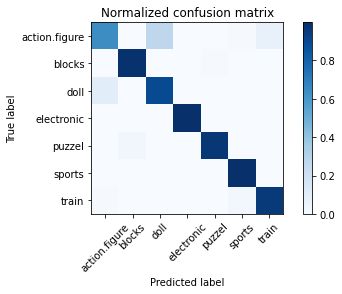

In [14]:
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, predict_classes)
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, products, 
        title='Normalized confusion matrix')

plt.show()